# <center> Finding connected components in graph </center>

<center> by Jawher Jabri, Firas Meddeb, Mohamed Achref Langliz </center>

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=f12fbe1a9e90dfe0e4bcc0a0937b209b74a55793ee97bcf85546ec9d4ebc8bb0
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


# Implementation: 

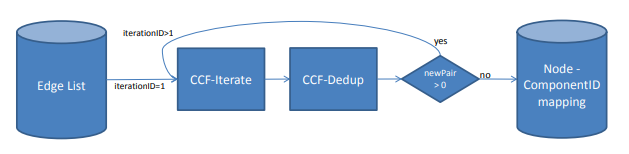

We introduce our CCF class with its functions to help us implement the algorithm presented in the paper using MapReduce framework. 

The CCF class is defined with the following methods:

* **__init__**: initializes an instance of the CCF class.
* **ccf_iterate**: performs one iteration of the CCF algorithm using the naive method.
* **ccf_iterate_secondary_sorting**: performs one iteration of the CCF algorithm using the secondary sorting method.
* **process**: applies the CCF algorithm to an input RDD.

In [2]:
from pyspark import SparkContext, RDD
import time

class CCF:

    def __init__(self):
        self.new_pairs = 0
    

    ## FlatMap operation : 
    #  The key-value pairs are transformed into a new set of key-value pairs by creating two pairs for each input pair.
    #  The first pair has the same key-value pair as the input pair, and the second pair has the key and value swapped.
    ## First map operation : 
    #  The first element is the original key, the second element is a list of all the values associated with the key from groupbykey operation,
    #  and the third element is the minimum value in that list. 
    ## Filter operation : 
    #  Only pairs where the original key is greater than the minimum value are kept
    ## Second map operation : 
    #  It creates the new key-value pairs that will be used to update the original RDD.

    def ccf_iterate(self, rdd: RDD) -> RDD:
        processed_rdd = rdd.flatMap(lambda x: [(x[0], x[1]), (x[1], x[0])]) \
                          .groupByKey() \
                          .map(lambda x: (x[0], list(x[1]), min(x[1]))) \
                          .filter(lambda x: x[0] > x[2]) \
                          .map(lambda x: (x[0], [y for y in x[1] if y != x[2]], x[2]))

        self.new_pairs = processed_rdd.map(lambda x: len(x[1])).sum()  # get number of new pairs created
        print(f"# new pairs : {self.new_pairs}")

        return processed_rdd.flatMap(lambda x: [(x[0], x[2])] + [(y, x[2]) for y in x[1]]).distinct()



    ## mapValues operation : 
    #  The function takes each group of tuples and sorts the values and converts the resulting iterator into a list.
    ## filter operation : 
    #  Keeps only tuples where the first element is greater than the smallest value in the list of values
    ## map operation : 
    #  creates a new tuple with the same key and a list of values that includes all values except the smallest value, as well as the smallest value itself.
    def ccf_iterate_secondary_sorting(self, rdd: RDD) -> RDD:
        processed_rdd = rdd.flatMap(lambda x: [(x[0], x[1]), (x[1], x[0])]) \
                          .groupByKey() \
                          .mapValues(lambda x: sorted(list(x))) \
                          .filter(lambda x: x[0] > x[1][0]) \
                          .map(lambda x: (x[0], x[1][1:], x[1][0]))

        
        # get number of new pairs created
        self.new_pairs = processed_rdd.map(lambda x: len(x[1])).sum()  
        print(f"# new pairs : {self.new_pairs}")

        return processed_rdd.flatMap(lambda x: [(x[0], x[2])] + [(y, x[2]) for y in x[1]]).distinct()



    # The purpose of this method is to perform iterative processing of the input RDD using either ccf_iterate or ccf_iterate_secondary_sorting.
    # This iterative process continues until no new pairs are generated by the processing, at which point the method returns the final RDD.
    def process(self, rdd: RDD, secondary_sorting: bool) -> RDD:
        i = 0
        current_rdd = rdd
        while True:
            print(f"iteration {i}")
            if secondary_sorting:
                current_rdd = self.ccf_iterate_secondary_sorting(current_rdd)
            else:
                current_rdd = self.ccf_iterate(current_rdd)
            i += 1
            if self.new_pairs == 0:
                break

        n_components = current_rdd.map(lambda x: x[1]).distinct().count()
        largest_component = current_rdd.groupBy(lambda x: x[1]).map(lambda x: len(x[1]) + 1).max()
        print(f"\nN components : {n_components}")
        print(f"The largest component has {largest_component} elements")

        return current_rdd


# Experiment : 

## Graph in Figure 5 in the paper:

In this part we will try our implementaion on the small graph illustrated in the paper. 
Here's our encoding of graph : 
* 1 : A 
* 2 : B 
* 3 : C 
* 4 : D 
* 5 : E 
* 6 : F 
* 7 : G 
* 8 : H 


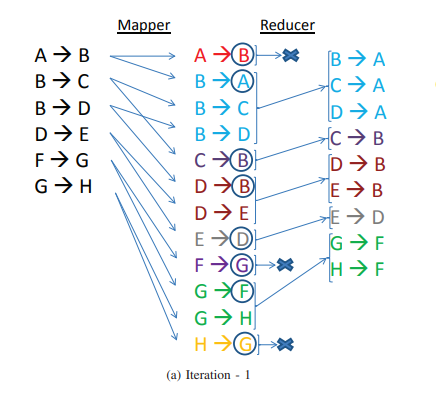

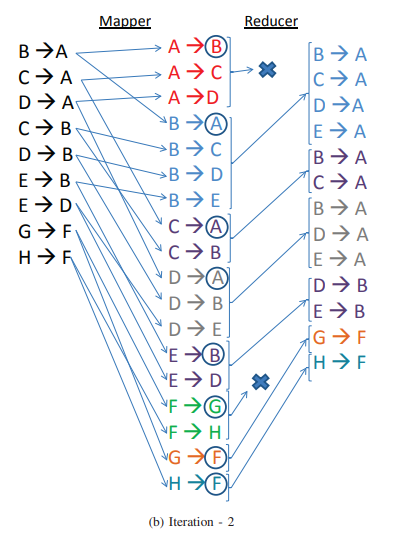

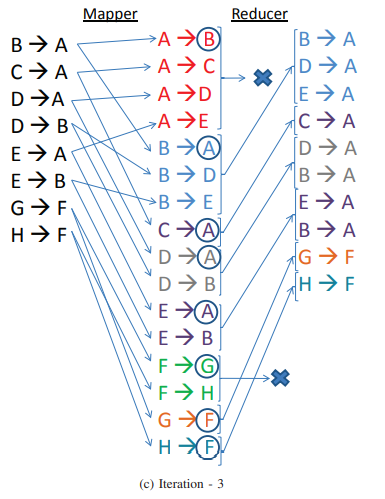

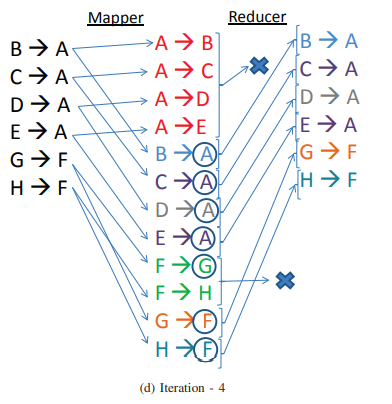

In [3]:
from pyspark import SparkContext

# create SparkContext
sc = SparkContext("local", "example")

# get dummy data
rdd_example = sc.parallelize([(1,2), (2, 3), (2, 4), (4, 5), (6, 7), (7, 8)])
rdd_example.collect()

[(1, 2), (2, 3), (2, 4), (4, 5), (6, 7), (7, 8)]

In [4]:
ccf = CCF()
output_example = ccf.process(rdd_example, False)
output_example.collect()


iteration 0
# new pairs : 4
iteration 1
# new pairs : 9
iteration 2
# new pairs : 4
iteration 3
# new pairs : 0

N components : 2
The largest component has 5 elements


[(2, 1), (5, 1), (4, 1), (3, 1), (7, 6), (8, 6)]

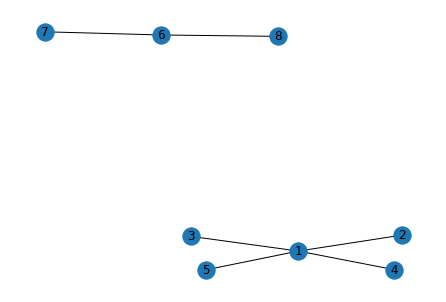

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# define the edges and nodes of the graph
edges = output_example.collect()
nodes = list(set([u for e in edges for u in e]))

# create an empty graph
G = nx.Graph()

# add the edges and nodes to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# draw the graph
nx.draw(G, with_labels=True)
plt.show()


Our results align with the ones found in the paper.

## web-Google

We need to download the dataset used in the paper to validate our code.

In [5]:
! curl -sk http://snap.stanford.edu/data/web-Google.txt.gz | gzip -d | tail -n +5 > data.txt && cat data.txt | head -n10

0	11342
0	824020
0	867923
0	891835
11342	0
11342	27469
11342	38716
11342	309564
11342	322178
11342	387543


In [6]:
rdd_input = sc.textFile("data.txt") \
               .map(lambda x: x.split("\t")) \
               .map(lambda x: (int(x[0]), int(x[1])))

In [7]:
rdd_input.collect() [:10]

[(0, 11342),
 (0, 824020),
 (0, 867923),
 (0, 891835),
 (11342, 0),
 (11342, 27469),
 (11342, 38716),
 (11342, 309564),
 (11342, 322178),
 (11342, 387543)]

In [8]:
c1 = rdd_input.count()
print("N edges (directed graph) : ", c1)
rdd_undirected = rdd_input.map(lambda x: (x[1], x[0]) if x[0] > x[1] else x) \
                          .distinct()
c2 = rdd_undirected.count()
print("N edges (undirected graph) : ", c2)


N edges (directed graph) :  5105039
N edges (undirected graph) :  4322051


In [9]:
# Run the process method with secondary sorting interation
start = time.process_time()
ccf = CCF()
rdd_output_secondary = ccf.process(rdd_undirected, True)

end = time.process_time()
print("Processing time: {}".format(end - start))

iteration 0
# new pairs : 7223780
iteration 1
# new pairs : 4758451
iteration 2
# new pairs : 3278772
iteration 3
# new pairs : 3888454
iteration 4
# new pairs : 1905323
iteration 5
# new pairs : 86783
iteration 6
# new pairs : 1318
iteration 7
# new pairs : 0

N components : 2746
The largest component has 855802 elements
Processing time: 2.247323604


In [10]:
# Run the process method with naive iteration
start = time.process_time()
ccf = CCF()
rdd_output_naive = ccf.process(rdd_undirected, False)

end = time.process_time()
print("Processing time: {}".format(end - start))

iteration 0
# new pairs : 7223780
iteration 1
# new pairs : 4758451
iteration 2
# new pairs : 3278772
iteration 3
# new pairs : 3888454
iteration 4
# new pairs : 1905323
iteration 5
# new pairs : 86783
iteration 6
# new pairs : 1318
iteration 7
# new pairs : 0

N components : 2746
The largest component has 855802 elements
Processing time: 2.253738042


In [28]:
len(rdd_output_naive.collect())

872967

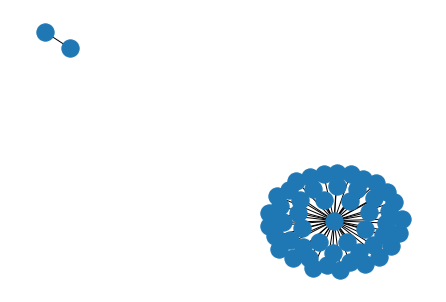

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# define the edges and nodes of the graph
edges1 = rdd_output_naive.collect()

num_edges_to_visualize = 50
edges_to_visualize = random.sample(edges1, num_edges_to_visualize)


# create an empty graph
G1 = nx.Graph()

# add the edges to the graph
G1.add_edges_from(edges_to_visualize)

# draw the graph
nx.draw(G1, with_labels=False)
plt.show()


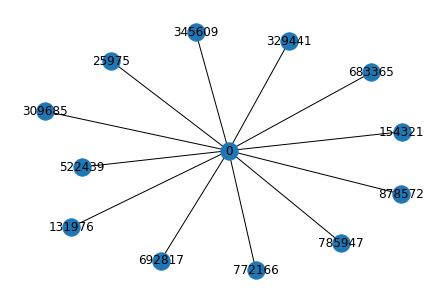

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# define the edges and nodes of the graph
edges1 = rdd_output_naive.collect()

num_edges_to_visualize = 12
edges_to_visualize = random.sample(edges1, num_edges_to_visualize)


# create an empty graph
G1 = nx.Graph()

# add the edges to the graph
G1.add_edges_from(edges_to_visualize)

# draw the graph
nx.draw(G1, with_labels=True)
plt.show()


In [11]:
# count the number of connected components and save the output
count_components = rdd_output_naive.groupBy(lambda x: x[1]).mapValues(len).groupBy(lambda x: x[1]).mapValues(len)
count_components.coalesce(1).saveAsTextFile("output")

In [12]:
!cat output//part-00000 | sed -e "s/[\(\)]//g" -e "s/\,/\t/g" > counts.txt && cat counts.txt | head -n10

855801	 1
6	 150
318	 1
252	 1
36	 2
99	 1
18	 21
3	 279
12	 31
9	 63


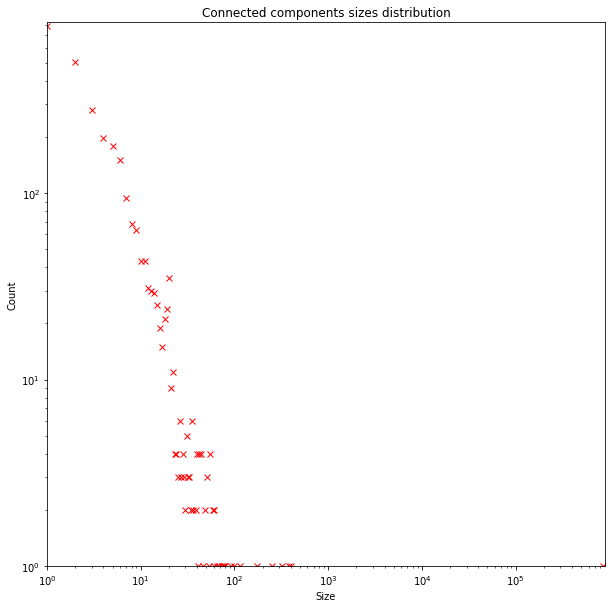

In [13]:
import matplotlib.pyplot as plt
import numpy as np

counts = np.loadtxt("counts.txt")

plt.figure(figsize=(10,10))
X = counts[:, 0]
Y = counts[:, 1]
plt.plot(X, Y, 'rx')
plt.xlim(left=1)  
plt.ylim(bottom=1) 

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Connected components sizes distribution')

plt.show()

## web-Stanford

We need to download the dataset used in the paper to validate our code.

In [15]:
! curl -sk http://snap.stanford.edu/data/web-Stanford.txt.gz | gzip -d | tail -n +5 > data1.txt && cat data1.txt | head -n10

1	6548
1	15409
6548	57031
15409	13102
2	17794
2	25202
2	53625
2	54582
2	64930
2	73764


In [16]:
rdd_input1 = sc.textFile("data1.txt") \
               .map(lambda x: x.split("\t")) \
               .map(lambda x: (int(x[0]), int(x[1])))

In [17]:
rdd_input1.collect() [:10]

[(1, 6548),
 (1, 15409),
 (6548, 57031),
 (15409, 13102),
 (2, 17794),
 (2, 25202),
 (2, 53625),
 (2, 54582),
 (2, 64930),
 (2, 73764)]

In [18]:
c1 = rdd_input1.count()
print("N edges (directed graph) : ", c1)
rdd_undirected1 = rdd_input1.map(lambda x: (x[1], x[0]) if x[0] > x[1] else x) \
                          .distinct()
c2 = rdd_undirected1.count()
print("N edges (undirected graph) : ", c2)


N edges (directed graph) :  2312497
N edges (undirected graph) :  1992636


In [19]:
# Run the process method with secondary sorting interation
start = time.process_time()
ccf = CCF()
rdd_output_secondary1 = ccf.process(rdd_undirected1, True)

end = time.process_time()
print("Processing time: {}".format(end - start))

iteration 0
# new pairs : 3525477
iteration 1
# new pairs : 1589872
iteration 2
# new pairs : 615319
iteration 3
# new pairs : 637840
iteration 4
# new pairs : 682238
iteration 5
# new pairs : 346183
iteration 6
# new pairs : 39590
iteration 7
# new pairs : 14304
iteration 8
# new pairs : 12120
iteration 9
# new pairs : 9734
iteration 10
# new pairs : 5535
iteration 11
# new pairs : 1491
iteration 12
# new pairs : 738
iteration 13
# new pairs : 0

N components : 365
The largest component has 255265 elements
Processing time: 1.208327185


In [20]:
# Run the process method with naive iteration
start = time.process_time()
ccf = CCF()
rdd_output_naive1 = ccf.process(rdd_undirected1, False)

end = time.process_time()
print("Processing time: {}".format(end - start))

iteration 0
# new pairs : 3525477
iteration 1
# new pairs : 1589872
iteration 2
# new pairs : 615319
iteration 3
# new pairs : 637840
iteration 4
# new pairs : 682238
iteration 5
# new pairs : 346183
iteration 6
# new pairs : 39590
iteration 7
# new pairs : 14304
iteration 8
# new pairs : 12120
iteration 9
# new pairs : 9734
iteration 10
# new pairs : 5535
iteration 11
# new pairs : 1491
iteration 12
# new pairs : 738
iteration 13
# new pairs : 0

N components : 365
The largest component has 255265 elements
Processing time: 1.1579420379999998


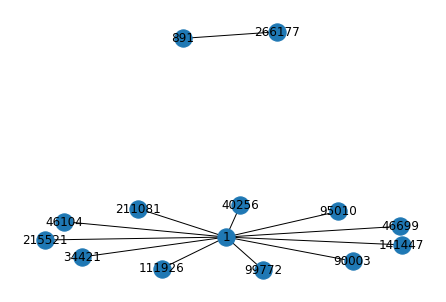

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# define the edges and nodes of the graph
edges2 = rdd_output_naive1.collect()

# randomly select a subset of edges
num_edges_to_visualize = 12
edges_to_visualize1 = random.sample(edges2, num_edges_to_visualize)


# create an empty graph
G2 = nx.Graph()

# add the edges to the graph
G2.add_edges_from(edges_to_visualize1)

# draw the graph
nx.draw(G2, with_labels=True)
plt.show()


In [21]:
# count the number of connected components and save the output
count_components = rdd_output_naive1.groupBy(lambda x: x[1]).mapValues(len).groupBy(lambda x: x[1]).mapValues(len)
count_components.coalesce(1).saveAsTextFile("output1")

In [22]:
!cat output1//part-00000 | sed -e "s/[\(\)]//g" -e "s/\,/\t/g" > counts1.txt && cat counts1.txt | head -n10

255264	 1
152	 1
507	 2
3	 20
627	 1
25	 1
130	 1
110	 1
524	 1
52	 2


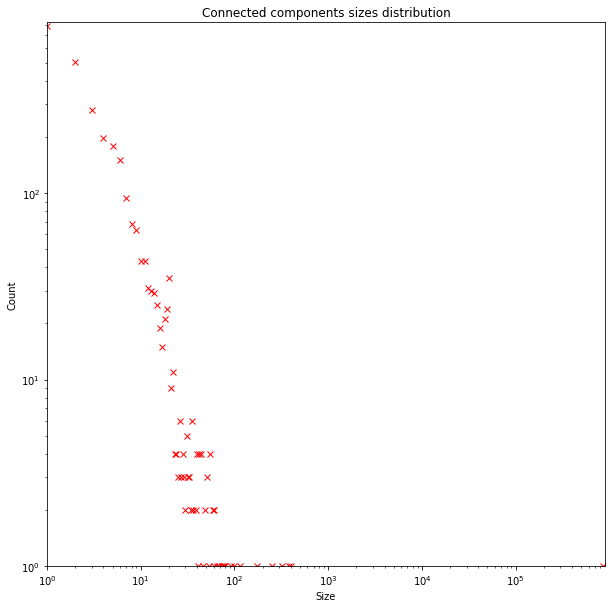

In [23]:
import matplotlib.pyplot as plt
import numpy as np

counts = np.loadtxt("counts.txt")

plt.figure(figsize=(10,10))
X = counts[:, 0]
Y = counts[:, 1]
plt.plot(X, Y, 'rx')
plt.xlim(left=1)  
plt.ylim(bottom=1) 

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Connected components sizes distribution')

plt.show()